In [48]:
import kachery_p2p as kp
import kachery as ka
import numpy as np

In [34]:
dirname = 'sha1dir://d40edb4e52ad5abef2c1689f7b04164fbf65271b.spike-sorting-conference-data'
dd = kp.read_dir(dirname)
for f in dd['files'].keys():
    print(f)

wheelData.mat
whitening_mat.npy
cluster_groups.csv
stimInfo.mat
Hopkins_20160722_g0_t0.imec.ap_CAR.bin
template_features.npy
amplitudes.npy
spike_templates.npy
template_feature_ind.npy
Hopkins_20160722_g0_t0.imec.lf.meta
script_plotRF.m
miniDataset.zip
templates.npy
pc_features.npy
channel_positions.npy
spike_times.npy
rawDataSample.bin
forPRBimecP3opt3.mat
similar_templates.npy
spike_clusters.npy
channel_map.npy
master_file.m
params.py
Hopkins_20160722_g0_t0.imec.lf.bin
pc_feature_ind.npy
Hopkins_20160722_g0_t0.imec.ap.meta
templates_ind.npy
whitening_mat_inv.npy
dataset.zip
Hopkins_20160722_g0_t0.imec.lf_sync.dat


In [92]:
def _listify_ndarray(x):
    if x.ndim == 1:
        if np.issubdtype(x.dtype, np.integer):
            return [int(val) for val in x]
        else:
            return [float(val) for val in x]
    elif x.ndim == 2:
        ret = []
        for j in range(x.shape[1]):
            ret.append(_listify_ndarray(x[:, j]))
        return ret
    elif x.ndim == 3:
        ret = []
        for j in range(x.shape[2]):
            ret.append(_listify_ndarray(x[:, :, j]))
        return ret
    elif x.ndim == 4:
        ret = []
        for j in range(x.shape[3]):
            ret.append(_listify_ndarray(x[:, :, :, j]))
        return ret
    else:
        raise Exception('Cannot listify ndarray with {} dims.'.format(x.ndim))

def create_recording_object(dirname, bin_fname, num_channels, samplerate):
    dd = kp.read_dir(dirname)
    bin_sha1 = dd['files'][bin_fname]['sha1']
    bin_size = dd['files'][bin_fname]['size']
    bin_uri = f'sha1://{bin_sha1}/raw.bin'
    channel_map = kp.load_npy(dirname + '/channel_map.npy')
    channel_positions = kp.load_npy(dirname + '/channel_positions.npy')
    num_frames = int(bin_size / num_channels / 2)
    assert num_frames * num_channels * 2 == bin_size, f'Unexpected size of bin file: {bin_size} <> {num_frames * num_channels * 2}'
    return dict(
        recording_format='bin1',
        data=dict(
            raw=bin_uri,
            num_channels=num_channels,
            num_frames=num_frames,
            samplerate=samplerate,
            channel_map=_listify_ndarray(channel_map.ravel()),
            channel_positions=_listify_ndarray(channel_positions)
        )
    )

obj = create_recording_object(
    dirname='sha1dir://d40edb4e52ad5abef2c1689f7b04164fbf65271b.cortexlab-single-phase-3',
    bin_fname='Hopkins_20160722_g0_t0.imec.ap_CAR.bin',
    num_channels=385,
    samplerate=30000
)

In [114]:
import spikeextractors as se
class Bin1RecordingExtractor(se.RecordingExtractor):
    extractor_name = 'Bin1RecordingExtractor'
    is_writable = False
    def __init__(self, *, raw, num_frames, num_channels, samplerate, channel_map, channel_positions):
        se.RecordingExtractor.__init__(self)
        
        self._raw = raw
        self._num_frames = num_frames
        self._num_channels = num_channels
        self._samplerate = samplerate
        self._channel_map = np.array(channel_map)
        self._channel_positions = np.array(channel_positions)
        
        self._channel_ids = np.arange(self._channel_positions.shape[1])
        for id in self._channel_ids:
            pos = self._channel_positions[:, id]
            self.set_channel_property(id, 'location', [pos[0], pos[1]])

    def get_channel_ids(self):
        return self._channel_ids

    def get_num_frames(self):
        return self._num_frames

    def get_sampling_frequency(self):
        return self._samplerate

    def get_traces(self, channel_ids=None, start_frame=None, end_frame=None):
        if start_frame is None:
            start_frame = 0
        if end_frame is None:
            end_frame = self._num_frames
        if channel_ids is None:
            channel_ids = self._channel_ids
        M = len(channel_ids)
        N = end_frame - start_frame
        
        i1 = start_frame * 2 * self._num_channels
        i2 = end_frame * 2 * self._num_channels
        
        buf = kp.load_bytes(self._raw, start=i1, end=i2)
        X = np.frombuffer(buf, dtype=np.int16).reshape((end_frame - start_frame, self._num_channels))
        
        ret = np.zeros((M, N))
        for m in range(M):
            ret[m, :] = X[:, self._channel_map[m]]
        
        return ret

In [115]:
R = Bin1RecordingExtractor(
    raw=obj['data']['raw'],
    num_frames=obj['data']['num_frames'],
    num_channels=obj['data']['num_channels'],
    samplerate=obj['data']['samplerate'],
    channel_map=obj['data']['channel_map'],
    channel_positions=obj['data']['channel_positions']
)

In [116]:
R.get_num_frames() / R.get_sampling_frequency() / 60 / 60

1.0482293333333332

In [117]:
t = R.get_traces(channel_ids=[0, 1, 2], start_frame=0, end_frame=30000)

In [101]:
t.shape

(3, 150000)

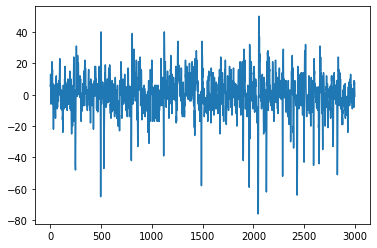

In [109]:
from matplotlib import pyplot as plt
plt.plot(t[0, 44000:47000].T);

In [43]:
def load_1sec():
    dirname = 'sha1dir://d40edb4e52ad5abef2c1689f7b04164fbf65271b.spike-sorting-conference-data'
    raw_fname = dirname + '/Hopkins_20160722_g0_t0.imec.ap_CAR.bin'
    samplerate = 30000
    channel_map = kp.load_npy(dirname + '/channel_map.npy')
    buf_1sec = kp.load_bytes(raw_fname, start=0, end=385 * 2 * samplerate * 1)
    raw_1sec = np.frombuffer(buf_1sec, dtype=np.int16).reshape((samplerate, 385))
    return raw_1sec, channel_map

In [44]:
x, channel_map = load_1sec()

In [45]:
channel_map.shape

(374, 1)

In [17]:
x = kp.load_npy(dirname + '/channel_positions.npy')

Downloaded 6064 bytes in 0.5499560832977295 sec (0.010515532476720902 MB/sec)


In [118]:
import spikewidgets as sw

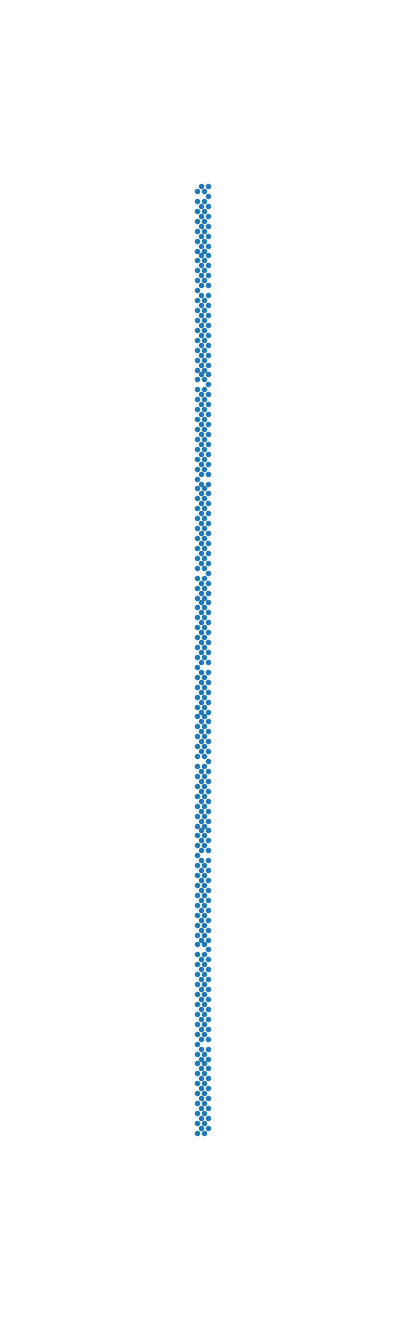

In [127]:
plt.figure(figsize=(7, 24))
sw.plot_electrode_geometry(ax=plt.gca(), recording=R)

In [125]:
384/32

12.0

In [20]:
dd['files']['Hopkins_20160722_g0_t0.imec.ap_CAR.bin']

{'size': 87170751360, 'sha1': '1b8592f0240603ae1019379cb47bad6475503aaf'}

In [26]:
int(87170751360/385) * 385

87170751360

In [24]:
print(kp.load_text(dirname + '/params.py'))

dat_path = 'Hopkins_20160722_g0_t0.imec.ap_CAR.bin'
n_channels_dat = 385
dtype = 'int16'
offset = 0
sample_rate = 30000
hp_filtered = False


In [29]:
a = kp.load_bytes(dirname + '/Hopkins_20160722_g0_t0.imec.ap_CAR.bin', start=0, end=385 * 1000)

In [31]:
print(len(a))

385000
